# 1st module

## Load the dataset

Load the dataset mat file.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sb

dataset_fname = "datasets/dataset_static.mat"

mat_contents = sio.loadmat(dataset_fname)
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'parsedData'])

The data is on the mat file variable. In this case: `parsedData`.

In [2]:
mat_var = "parsedData"

mdata = mat_contents[mat_var]
data = dict()
for col in mdata.dtype.names:
    mdata_col = mdata[col][0]
    # probe first col element to find if it's a dumb single item array (loving it)
    is_single_elem = len(mdata_col[0][0]) == 1
    data[col] = [d[0][0] if is_single_elem else d[0].tolist() for d in mdata_col]

data.keys()

dict_keys(['time', 'angle', 'step_dist', 'intensities'])

We'll build a dataframe because they're cool.

In [3]:
df = pd.DataFrame(data)
df.head()

,time,angle,step_dist,intensities
0,10.280058,180.000000,0.012531,"[0, 0, 0, 0, 43, 68, 90, 106, 111, 108, 100, 9..."
1,10.321921,181.800003,0.012531,"[0, 0, 0, 17, 51, 73, 87, 106, 116, 117, 92, 9..."
2,10.364880,183.600006,0.012531,"[0, 0, 0, 11, 43, 63, 84, 106, 119, 119, 103, ..."
3,10.408035,185.399994,0.012531,"[0, 0, 0, 0, 55, 76, 94, 108, 113, 113, 100, 1..."
4,10.451024,187.199997,0.012531,"[0, 0, 0, 15, 44, 63, 78, 102, 113, 113, 109, ..."


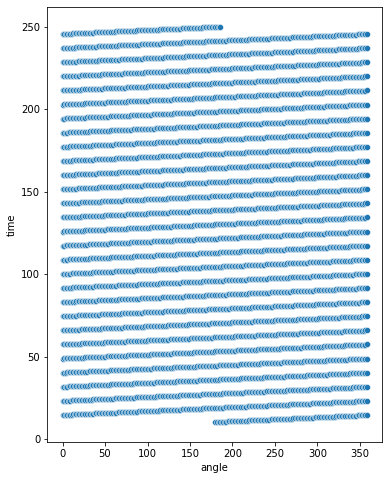

In [4]:
plt.figure(figsize=(6.0, 8.0))
sb.scatterplot(data=df, x="angle", y="time");

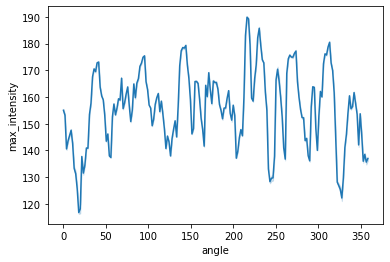

In [5]:
df['max_intensity'] = df.apply(lambda x: max(x["intensities"]), axis=1)
sb.lineplot(data=df, x="angle", y="max_intensity");

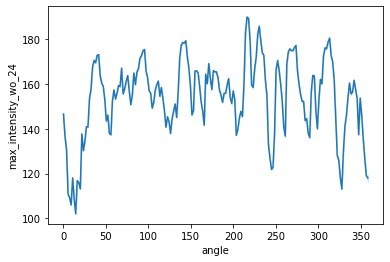

In [6]:
df["intensities_wo_24"] = df.apply(lambda x: x["intensities"][24:], axis=1)
df['max_intensity_wo_24'] = df.apply(lambda x: max(x["intensities_wo_24"]), axis=1)
sb.lineplot(data=df, x="angle", y="max_intensity_wo_24");

## Grid map

Sonar calibrated for:

- 5 meters;
- Bit length of $1.25 * 10^-2$ meters;
- Angle step of $1.8º$.

With leads to:

- $\frac{5.0}{1.25 * 10^-2} = 400$ - 400 bins per array;
- $360º / 1.8º = 200$ - 200 arrays;

In [8]:
# A Scan has multiple sweeps. Each sweep sends multiple beams in 360º
angle_step = abs(df.iloc[1]["angle"] - df.iloc[0]["angle"])
sweep_len = round(360 / angle_step)
scan_len = round(len(df.index) / sweep_len)

(angle_step, sweep_len, scan_len)

(1.800003, 200, 28)

In [9]:
df

,time,angle,step_dist,intensities,max_intensity,intensities_wo_24,max_intensity_wo_24
0,10.280058,180.000000,0.012531,"[0, 0, 0, 0, 43, 68, 90, 106, 111, 108, 100, 9...",165,"[35, 30, 17, 17, 9, 0, 0, 1, 0, 12, 25, 0, 0, ...",165
1,10.321921,181.800003,0.012531,"[0, 0, 0, 17, 51, 73, 87, 106, 116, 117, 92, 9...",160,"[35, 28, 11, 9, 0, 4, 0, 0, 0, 30, 47, 28, 12,...",160
2,10.364880,183.600006,0.012531,"[0, 0, 0, 11, 43, 63, 84, 106, 119, 119, 103, ...",157,"[47, 46, 11, 0, 0, 9, 0, 17, 12, 60, 74, 49, 1...",157
3,10.408035,185.399994,0.012531,"[0, 0, 0, 0, 55, 76, 94, 108, 113, 113, 100, 1...",153,"[52, 47, 14, 0, 0, 11, 9, 15, 17, 71, 81, 41, ...",153
4,10.451024,187.199997,0.012531,"[0, 0, 0, 15, 44, 63, 78, 102, 113, 113, 109, ...",151,"[55, 46, 4, 0, 0, 4, 4, 0, 0, 73, 79, 41, 0, 7...",151
...,...,...,...,...,...,...,...
5599,249.791718,178.199997,0.012531,"[0, 0, 0, 20, 51, 71, 89, 102, 105, 98, 113, 1...",165,"[23, 19, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4...",165
5600,249.834717,180.000000,0.012531,"[0, 0, 0, 27, 49, 68, 82, 103, 109, 111, 97, 9...",165,"[46, 30, 7, 9, 0, 0, 30, 30, 0, 0, 19, 0, 0, 1...",165
5601,249.877716,181.800003,0.012531,"[0, 0, 0, 25, 57, 74, 86, 98, 111, 113, 106, 9...",164,"[49, 31, 15, 11, 0, 0, 49, 47, 0, 19, 36, 25, ...",164
5602,249.920715,183.600006,0.012531,"[0, 0, 0, 11, 47, 71, 82, 105, 117, 119, 109, ...",159,"[46, 36, 9, 0, 0, 1, 41, 41, 14, 57, 71, 43, 1...",159


In [10]:
def getSweep(i):
    # If the first beam is done at 365 and the second is done at 0 this breaks :), but is ok
    return df.iloc[i*sweep_len: (i + 1) * sweep_len]

first_scan = getSweep(0)

first_scan

,time,angle,step_dist,intensities,max_intensity,intensities_wo_24,max_intensity_wo_24
0,10.280058,180.000000,0.012531,"[0, 0, 0, 0, 43, 68, 90, 106, 111, 108, 100, 9...",165,"[35, 30, 17, 17, 9, 0, 0, 1, 0, 12, 25, 0, 0, ...",165
1,10.321921,181.800003,0.012531,"[0, 0, 0, 17, 51, 73, 87, 106, 116, 117, 92, 9...",160,"[35, 28, 11, 9, 0, 4, 0, 0, 0, 30, 47, 28, 12,...",160
2,10.364880,183.600006,0.012531,"[0, 0, 0, 11, 43, 63, 84, 106, 119, 119, 103, ...",157,"[47, 46, 11, 0, 0, 9, 0, 17, 12, 60, 74, 49, 1...",157
3,10.408035,185.399994,0.012531,"[0, 0, 0, 0, 55, 76, 94, 108, 113, 113, 100, 1...",153,"[52, 47, 14, 0, 0, 11, 9, 15, 17, 71, 81, 41, ...",153
4,10.451024,187.199997,0.012531,"[0, 0, 0, 15, 44, 63, 78, 102, 113, 113, 109, ...",151,"[55, 46, 4, 0, 0, 4, 4, 0, 0, 73, 79, 41, 0, 7...",151
...,...,...,...,...,...,...,...
195,18.621433,171.000000,0.012531,"[0, 0, 0, 19, 38, 68, 86, 100, 102, 92, 105, 1...",168,"[19, 15, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",168
196,18.664427,172.800003,0.012531,"[0, 0, 0, 15, 41, 65, 84, 98, 102, 94, 95, 92,...",162,"[36, 33, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",162
197,18.706421,174.600006,0.012531,"[0, 0, 0, 22, 52, 73, 89, 100, 102, 95, 100, 9...",157,"[33, 23, 9, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",157
198,18.749483,176.399994,0.012531,"[0, 0, 22, 47, 66, 79, 97, 105, 105, 86, 79, 8...",165,"[30, 22, 22, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",165


### Average sonar beam frequency

In [11]:
scan = first_scan
s = 0
t = 0
for i in range(scan_len):
    for i in range(199):
        s += (scan.iloc[i + 1]["time"] - scan.iloc[i]["time"])

    t += 200
s / t

0.04256192207336426

## Export JSON

In [9]:
import json

scan = {}
# A Scan has multiple sweeps. Each sweep sends multiple beams in 360º
scan["scan_len"] = scan_len
scan["sweep_len"] = sweep_len
scan["beam_len"] = int(len(df.loc[0]["intensities"]))
scan["step_dist"] = float(df.loc[0]["step_dist"])

sweeps = []
for i in range(scan_len):
    sweep = getSweep(i)
    beams = []
    for _, beam in sweep.iterrows():
        if len(beam["intensities"]) == scan["beam_len"]:
            beam_json = {
                "time": beam["time"],
                "angle": beam["angle"],
                "intensities": beam["intensities"]
            }
            beams.append(beam_json)
    sweeps.append(beams)

scan["sweeps"] = sweeps
with open('data.json', 'w') as f:
    json.dump(scan, f)

In [10]:
def getMinMaxIntensity(scan):
    minmax = scan["intensities"].apply(lambda row: (min(row), max(row)))
    mini = minmax[0][0]
    maxi = minmax[0][1]
    for mm in minmax:
        if mini > mm[0]:
            mini = mm[0]
        if maxi < mm[1]:
            maxi = mm[1]
    return (mini, maxi)

getMinMaxIntensity(first_scan)

(0, 191)

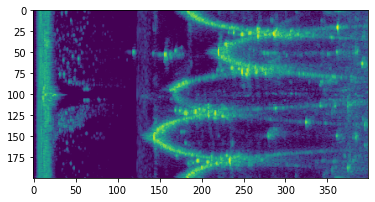

In [11]:
import matplotlib.image as mpimg
import png

def genPolarImg(scan, scale=1, outfile="polar.png"):
    img = []
    for index, scanrow in scan.iterrows():
        row = ()
        for intensity in scanrow["intensities"]:
            pixel = intensity
            row += (pixel,) * scale
        for i in range(scale):
            img.append(row)
    
    with open(outfile, "wb+") as f:
        w = png.Writer(len(img[0]), len(img), greyscale=True)
        w.write(f, img)
    plt.imshow(mpimg.imread(outfile));

genPolarImg(first_scan)

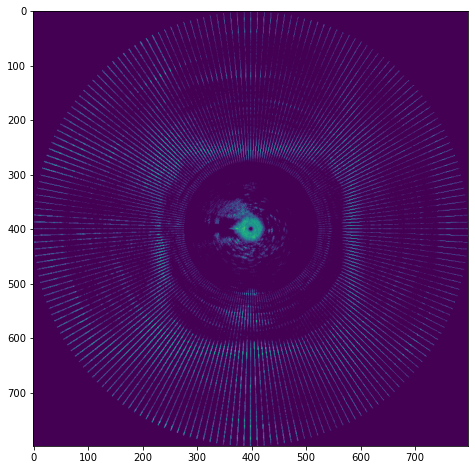

In [14]:
from math import radians, cos, sin, ceil

beam_width = 3

def genCartImg(scan, outfile="cartesian.png"):
    s = ceil(len(first_scan.iloc[0]["intensities"])) * 2
    img_pre = [[(0, 0) for _ in range(s)] for _ in range(s)]
    x0 = s//2
    y0 = s//2
    
    # we need to keep count of the number of times a pixel is affected
    # and then get the mean of the values
    for index, scanrow in scan.iterrows():
        base_angle = scanrow["angle"]
        for angle in np.arange(base_angle - beam_width/2, base_angle + beam_width/2 + 0.1, 0.1):
            angle = radians(angle + 180)
            for i, intensity in enumerate(scanrow["intensities"]):
                x = x0 + round(i * cos(angle))
                y = y0 + round(i * sin(angle))
                pixel_info = img_pre[y][x]
                if (x==0):
                    print(intensity)
                img_pre[y][x] = (pixel_info[0]+intensity, pixel_info[1]+1)


    img = [[0 for _ in range(s)] for _ in range(s)]


    for y in range(s):
        for x in range(s):
            pixel_info = img_pre[y][x]
            if pixel_info[1] != 0: # we only care about updated pixels
                img[y][x] = round(pixel_info[0] / pixel_info[1])
    with open(outfile, "wb+") as f:
        w = png.Writer(s, s, greyscale=True)
        w.write(f, img)
    plt.figure(figsize=(8.0, 8.0))
    plt.imshow(mpimg.imread(outfile));

genCartImg(first_scan)

# The sonar has a $3º$ horizontal beam => we consider each measure's angle to belong in the interval `[angle - 1.5º, angle + 1.5º]`.